In [2]:
#!pip install fedot

In [6]:
import os
os.environ["MKL_NUM_THREADS"] = "10"
os.environ["NUMEXPR_NUM_THREADS"] = "10"
os.environ["OMP_NUM_THREADS"] = "10"

import torch
torch.set_num_threads(10)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [7]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()

In [27]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [47]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 3000
end = 4000
series = 'traffic'

if series == 'traffic':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [46]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-24 12:50:49,418 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 12:50:49,429 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:50:49,436 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-24 12:50:49,442 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:50:49,446 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-24 12:50:49,449 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-24 12:50:49,565 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 12:50:49,657 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:50:49,665 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 12:50:49,684 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:50:49,689 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 12:50:49,693 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-24 12:50:49,699 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-24 12:50:49,706 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.3 sec.


2022-11-24 12:50:49,710 - ApiComposer - Initial pipeline was fitted in 0.3 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'locf', 'stl_arima', 'sgdr', 'lagged', 'lasso', 'gaussian_filter', 'adareg', 'glm', 'arima', 'diff_filter', 'polyfit', 'pca', 'dtreg', 'scaling', 'fast_ica', 'ridge', 'cut', 'linear', 'normalization', 'ts_naive_average', 'smoothing', 'ets', 'ar']


2022-11-24 12:50:49,725 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'locf', 'stl_arima', 'sgdr', 'lagged', 'lasso', 'gaussian_filter', 'adareg', 'glm', 'arima', 'diff_filter', 'polyfit', 'pca', 'dtreg', 'scaling', 'fast_ica', 'ridge', 'cut', 'linear', 'normalization', 'ts_naive_average', 'smoothing', 'ets', 'ar']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-24 12:50:49,746 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-24 12:50:49,755 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 12:50:49,762 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-24 12:50:50,422 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 5.116428733705028, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-24 12:50:50,428 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 5.116428733705028, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 12:50:50,432 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.0 min


2022-11-24 12:50:50,437 - EvoGraphOptimizer - spent time: 0.0 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 12:50:51,910 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-24 12:51:02,970 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


2022-11-24 12:51:02,978 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-24 12:51:02,985 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.2 min


2022-11-24 12:51:02,989 - EvoGraphOptimizer - spent time: 0.2 min


INFO:root:EvoGraphOptimizer - Next population size: 20; max graph depth: 5


2022-11-24 12:51:02,993 - EvoGraphOptimizer - Next population size: 20; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 12:51:03,831 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-24 12:51:14,811 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


2022-11-24 12:51:14,818 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-24 12:51:14,824 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.4 min


2022-11-24 12:51:14,827 - EvoGraphOptimizer - spent time: 0.4 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-24 12:51:14,831 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-24 12:51:15,547 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-24 12:51:23,864 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


2022-11-24 12:51:23,873 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.4940182945366605, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.3}]


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2022-11-24 12:51:23,886 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.6 min


2022-11-24 12:51:23,892 - EvoGraphOptimizer - spent time: 0.6 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-24 12:51:23,896 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [00:34<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 0.569 min


2022-11-24 12:51:23,915 - OptimisationTimer - Composition time: 0.569 min


INFO:root:GPComposer - GP composition finished


2022-11-24 12:51:23,925 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-24 12:51:24,304 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-24 12:51:24,424 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, ridge, lagged]}


2022-11-24 12:51:24,435 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [ridge, ridge, lagged]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 12:51:24,448 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:51:24,453 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-24 12:51:24,462 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-24 12:51:24,468 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 12:51:24,477 - PrimaryNode - Predict in primary node by operation: lagged


2022-11-24 12:51:24,525 - OperationTypesRepository - Operation lagged not found in the repository


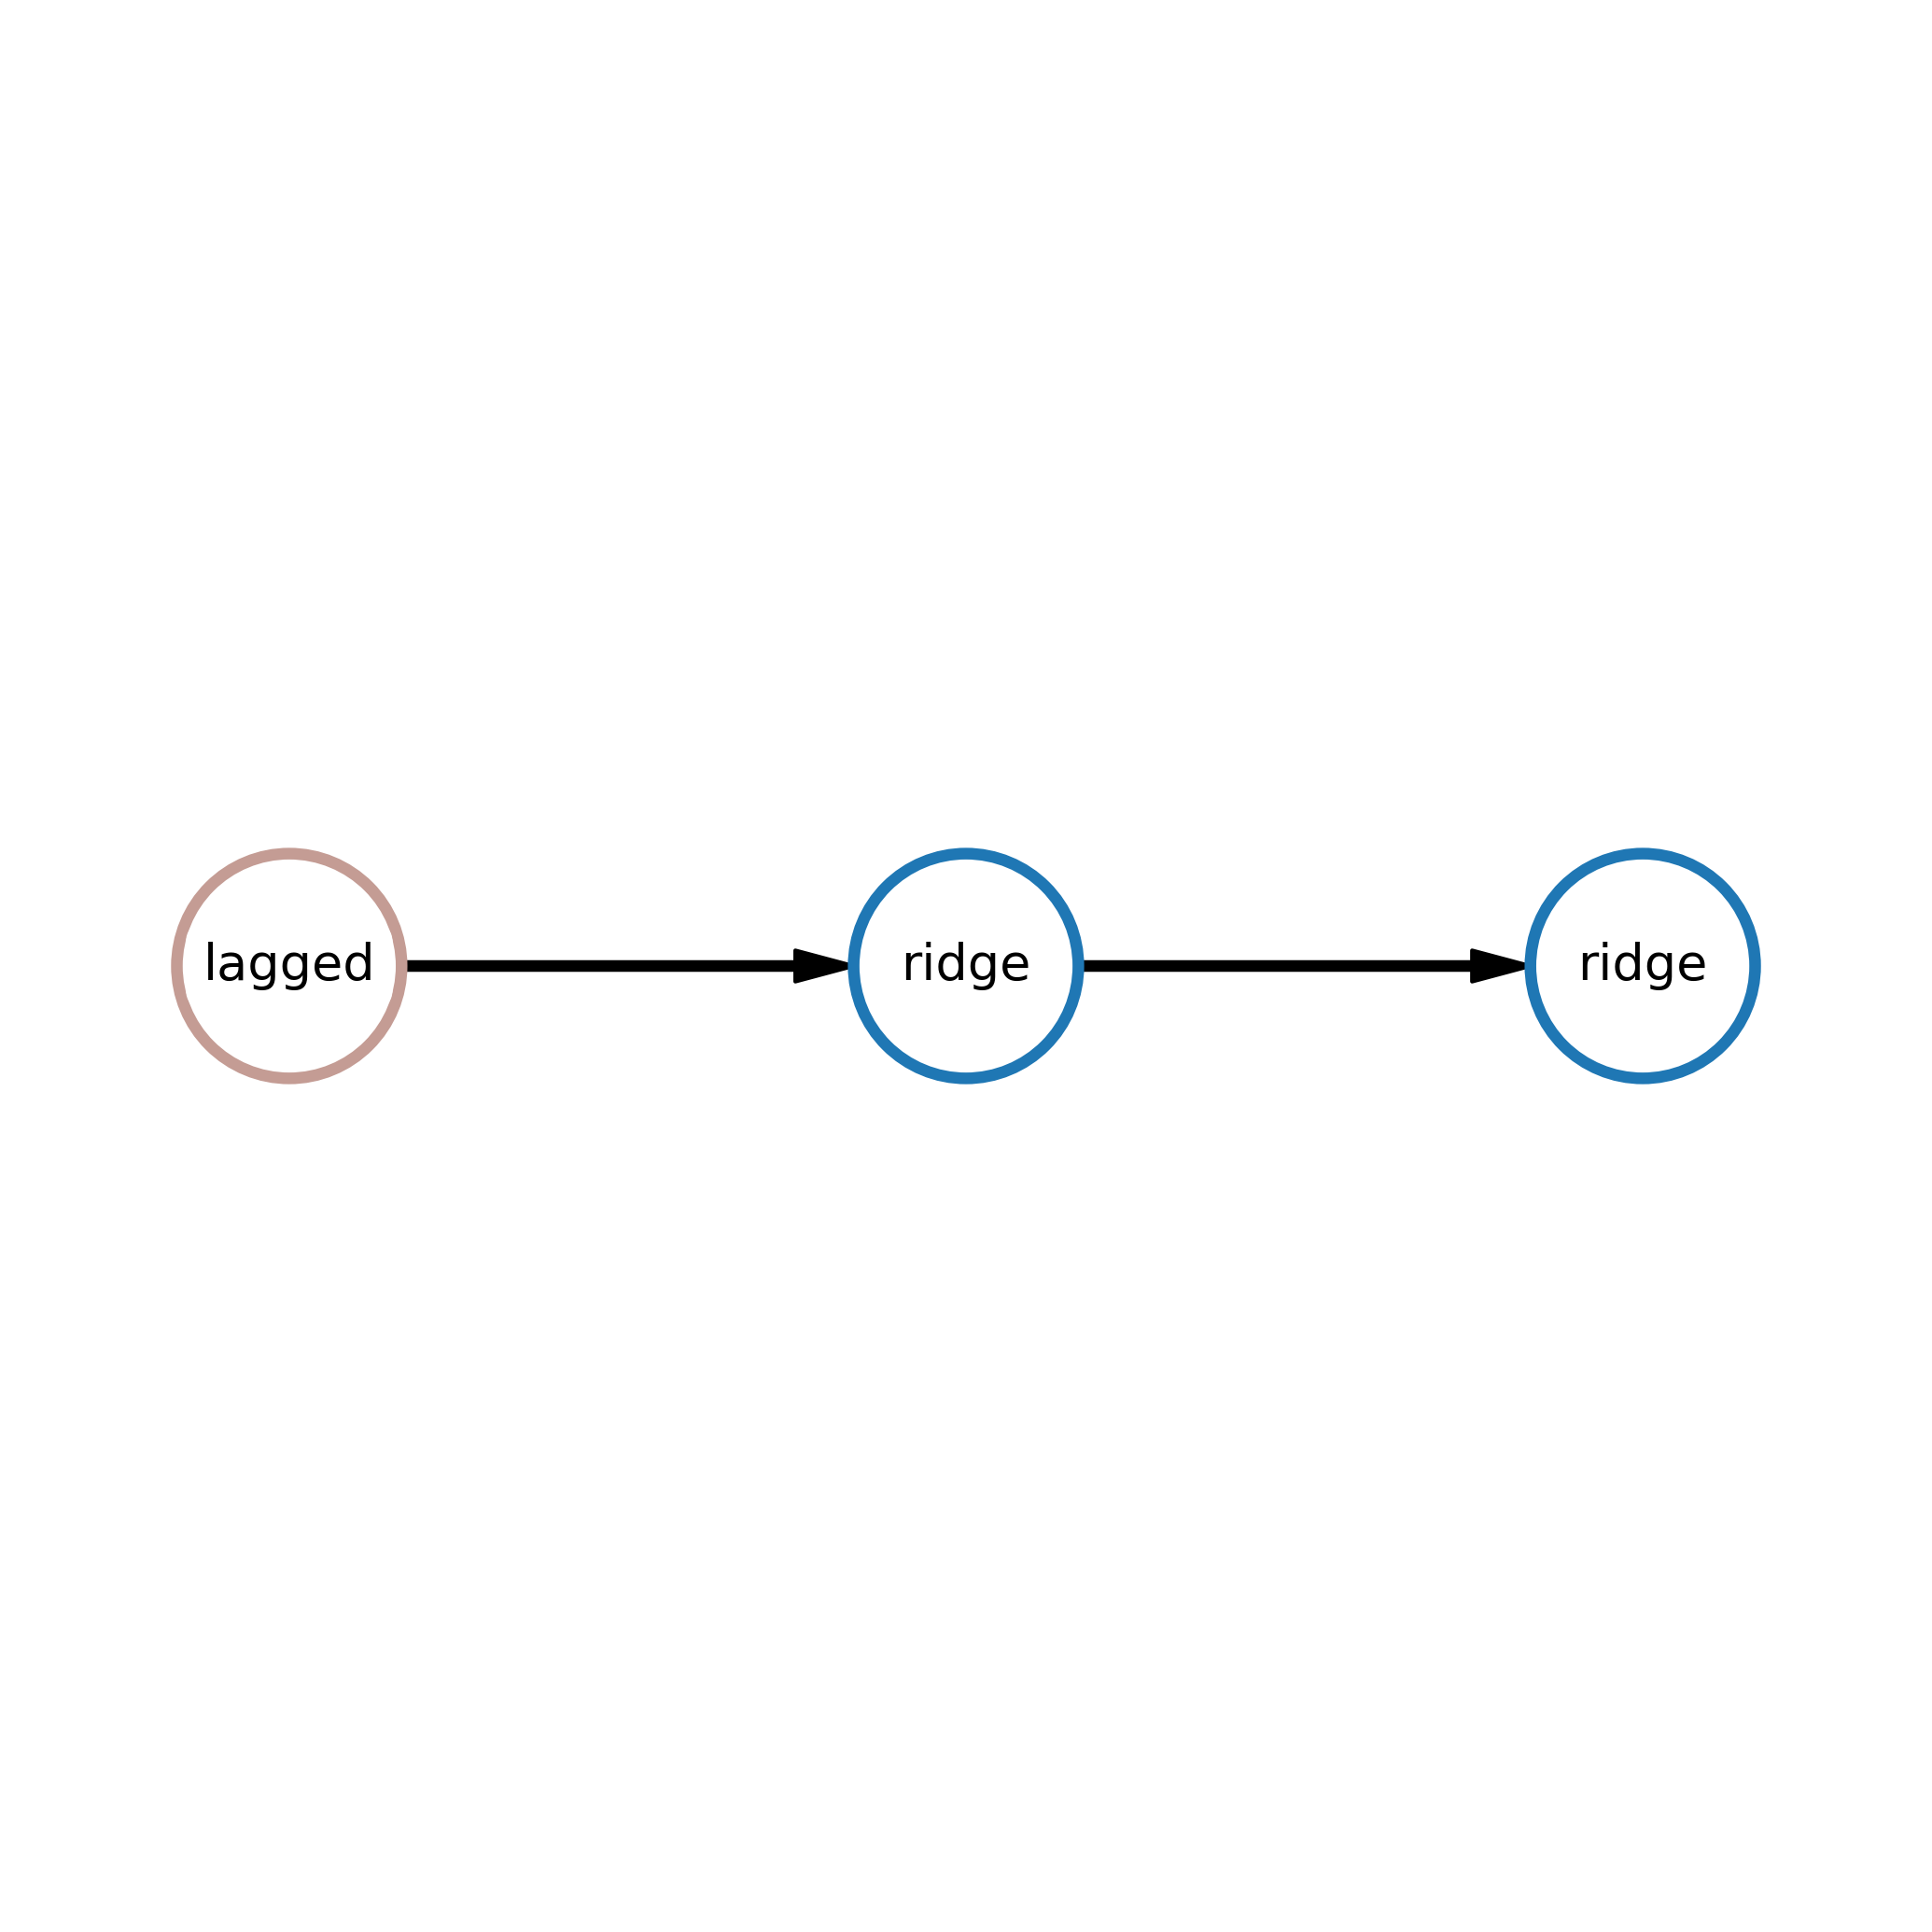

In [50]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

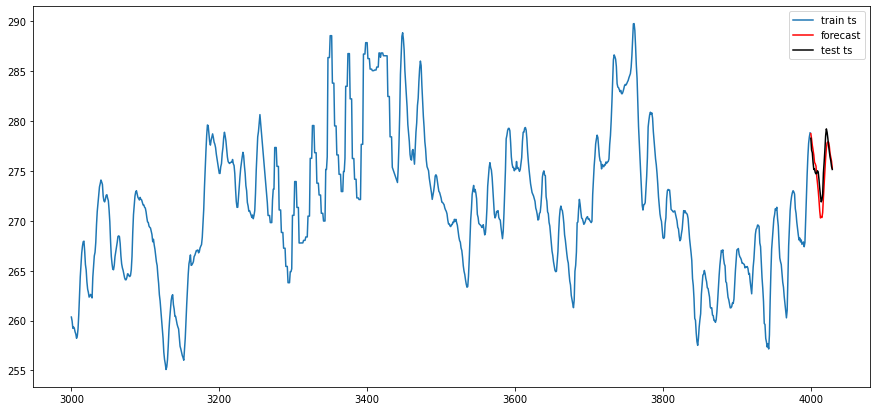

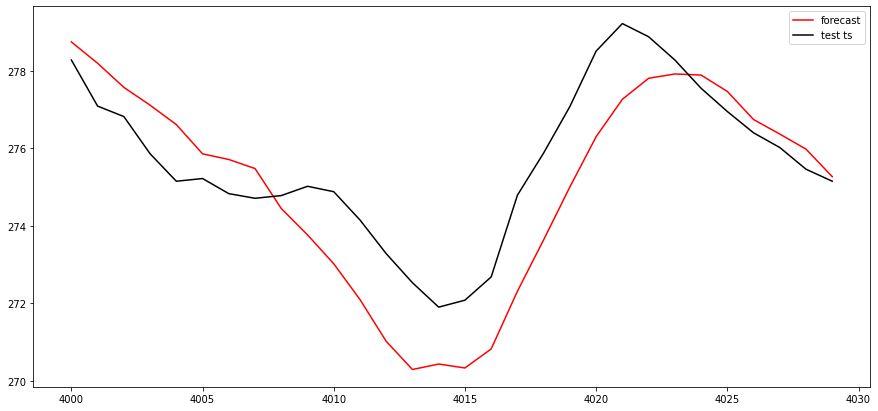

In [51]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [52]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [53]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 12:52:34,278 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-24 12:52:34,291 - DataSourceSplitter - Hold out validation is applied.


In [54]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [55]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [56]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [57]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-24 12:52:50,012 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002953 seconds


2022-11-24 12:52:50,144 - build_posterior_wrapper took 0.002953 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:52:50,150 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.02trial/s, best loss: 8.158006328044133]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004730 seconds


2022-11-24 12:52:51,131 - build_posterior_wrapper took 0.004730 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 8.158006


2022-11-24 12:52:51,138 - TPE using 1/1 trials with best loss 8.158006
 20%|██        | 2/10 [00:01<00:05,  1.48trial/s, best loss: 0.3920016709708546]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002960 seconds


2022-11-24 12:52:51,593 - build_posterior_wrapper took 0.002960 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.392002


2022-11-24 12:52:51,600 - TPE using 2/2 trials with best loss 0.392002
 30%|███       | 3/10 [00:02<00:06,  1.13trial/s, best loss: 0.3920016709708546]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004394 seconds


2022-11-24 12:52:52,728 - build_posterior_wrapper took 0.004394 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.392002


2022-11-24 12:52:52,735 - TPE using 3/3 trials with best loss 0.392002
 40%|████      | 4/10 [00:02<00:03,  1.64trial/s, best loss: 0.302223529442778] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002915 seconds


2022-11-24 12:52:52,919 - build_posterior_wrapper took 0.002915 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.302224


2022-11-24 12:52:52,931 - TPE using 4/4 trials with best loss 0.302224
 50%|█████     | 5/10 [00:03<00:02,  1.97trial/s, best loss: 0.302223529442778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003176 seconds


2022-11-24 12:52:53,245 - build_posterior_wrapper took 0.003176 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.302224


2022-11-24 12:52:53,257 - TPE using 5/5 trials with best loss 0.302224
 60%|██████    | 6/10 [00:03<00:01,  2.22trial/s, best loss: 0.302223529442778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002548 seconds


2022-11-24 12:52:53,575 - build_posterior_wrapper took 0.002548 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.302224


2022-11-24 12:52:53,587 - TPE using 6/6 trials with best loss 0.302224
 70%|███████   | 7/10 [00:03<00:01,  2.43trial/s, best loss: 0.302223529442778]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002510 seconds


2022-11-24 12:52:53,908 - build_posterior_wrapper took 0.002510 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.302224


2022-11-24 12:52:53,924 - TPE using 7/7 trials with best loss 0.302224
 80%|████████  | 8/10 [00:03<00:00,  2.93trial/s, best loss: 0.2995375629611646]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001896 seconds


2022-11-24 12:52:54,100 - build_posterior_wrapper took 0.001896 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.299538


2022-11-24 12:52:54,113 - TPE using 8/8 trials with best loss 0.299538
 90%|█████████ | 9/10 [00:04<00:00,  2.16trial/s, best loss: 0.2995375629611646]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003585 seconds


2022-11-24 12:52:54,837 - build_posterior_wrapper took 0.003585 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.299538


2022-11-24 12:52:54,844 - TPE using 9/9 trials with best loss 0.299538
100%|██████████| 10/10 [00:05<00:00,  1.80trial/s, best loss: 0.2995375629611646]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-24 12:52:55,894 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.300 equal or better than initial (+ 5% deviation) 0.407


2022-11-24 12:52:55,900 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.300 equal or better than initial (+ 5% deviation) 0.407


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:52:56,076 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002971 seconds


2022-11-24 12:52:56,264 - build_posterior_wrapper took 0.002971 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:52:56,271 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.25s/trial, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004061 seconds


2022-11-24 12:52:57,516 - build_posterior_wrapper took 0.004061 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.163587


2022-11-24 12:52:57,523 - TPE using 1/1 trials with best loss 1.163587
 20%|██        | 2/10 [00:02<00:07,  1.03trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002973 seconds


2022-11-24 12:52:58,297 - build_posterior_wrapper took 0.002973 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.163587


2022-11-24 12:52:58,304 - TPE using 2/2 trials with best loss 1.163587
 30%|███       | 3/10 [00:02<00:05,  1.33trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003391 seconds


2022-11-24 12:52:58,780 - build_posterior_wrapper took 0.003391 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.163587


2022-11-24 12:52:58,786 - TPE using 3/3 trials with best loss 1.163587
 40%|████      | 4/10 [00:03<00:05,  1.16trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003713 seconds


2022-11-24 12:52:59,819 - build_posterior_wrapper took 0.003713 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.163587


2022-11-24 12:52:59,826 - TPE using 4/4 trials with best loss 1.163587
 50%|█████     | 5/10 [00:03<00:03,  1.61trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003177 seconds


2022-11-24 12:53:00,009 - build_posterior_wrapper took 0.003177 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.163587


2022-11-24 12:53:00,016 - TPE using 5/5 trials with best loss 1.163587
 60%|██████    | 6/10 [00:04<00:02,  1.44trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003434 seconds


2022-11-24 12:53:00,841 - build_posterior_wrapper took 0.003434 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.163587


2022-11-24 12:53:00,848 - TPE using 6/6 trials with best loss 1.163587
 70%|███████   | 7/10 [00:04<00:01,  1.87trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003089 seconds


2022-11-24 12:53:01,047 - build_posterior_wrapper took 0.003089 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.163587


2022-11-24 12:53:01,058 - TPE using 7/7 trials with best loss 1.163587
 80%|████████  | 8/10 [00:05<00:01,  1.92trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002615 seconds


2022-11-24 12:53:01,542 - build_posterior_wrapper took 0.002615 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.163587


2022-11-24 12:53:01,559 - TPE using 8/8 trials with best loss 1.163587
 90%|█████████ | 9/10 [00:05<00:00,  1.82trial/s, best loss: 1.163586593910162]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002615 seconds


2022-11-24 12:53:02,156 - build_posterior_wrapper took 0.002615 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.163587


2022-11-24 12:53:02,168 - TPE using 9/9 trials with best loss 1.163587
100%|██████████| 10/10 [00:06<00:00,  1.64trial/s, best loss: 1.163586593910162]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:03,698 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.164 equal or better than initial (+ 5% deviation) 2.767


2022-11-24 12:53:03,708 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.164 equal or better than initial (+ 5% deviation) 2.767


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-24 12:53:05,079 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002480 seconds


2022-11-24 12:53:05,257 - build_posterior_wrapper took 0.002480 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:05,268 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.64trial/s, best loss: 0.552347617261612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003152 seconds


2022-11-24 12:53:05,875 - build_posterior_wrapper took 0.003152 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.552348


2022-11-24 12:53:05,890 - TPE using 1/1 trials with best loss 0.552348
 20%|██        | 2/10 [00:01<00:04,  1.64trial/s, best loss: 0.552347617261612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002600 seconds


2022-11-24 12:53:06,487 - build_posterior_wrapper took 0.002600 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.552348


2022-11-24 12:53:06,502 - TPE using 2/2 trials with best loss 0.552348
 30%|███       | 3/10 [00:02<00:05,  1.18trial/s, best loss: 0.552347617261612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002677 seconds


2022-11-24 12:53:07,610 - build_posterior_wrapper took 0.002677 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.552348


2022-11-24 12:53:07,614 - TPE using 3/3 trials with best loss 0.552348
 40%|████      | 4/10 [00:02<00:03,  1.64trial/s, best loss: 0.3289316327231426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002923 seconds


2022-11-24 12:53:07,863 - build_posterior_wrapper took 0.002923 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.328932


2022-11-24 12:53:07,874 - TPE using 4/4 trials with best loss 0.328932
 50%|█████     | 5/10 [00:03<00:03,  1.27trial/s, best loss: 0.3289316327231426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002569 seconds


2022-11-24 12:53:08,950 - build_posterior_wrapper took 0.002569 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.328932


2022-11-24 12:53:08,965 - TPE using 5/5 trials with best loss 0.328932
 60%|██████    | 6/10 [00:04<00:03,  1.17trial/s, best loss: 0.3289316327231426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002652 seconds


2022-11-24 12:53:09,949 - build_posterior_wrapper took 0.002652 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.328932


2022-11-24 12:53:09,961 - TPE using 6/6 trials with best loss 0.328932
 70%|███████   | 7/10 [00:05<00:02,  1.47trial/s, best loss: 0.3289316327231426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002878 seconds


2022-11-24 12:53:10,264 - build_posterior_wrapper took 0.002878 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.328932


2022-11-24 12:53:10,271 - TPE using 7/7 trials with best loss 0.328932
 80%|████████  | 8/10 [00:05<00:01,  1.31trial/s, best loss: 0.3289316327231426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002749 seconds


2022-11-24 12:53:11,206 - build_posterior_wrapper took 0.002749 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.328932


2022-11-24 12:53:11,213 - TPE using 8/8 trials with best loss 0.328932
 90%|█████████ | 9/10 [00:06<00:00,  1.72trial/s, best loss: 0.32031818454039523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002719 seconds


2022-11-24 12:53:11,390 - build_posterior_wrapper took 0.002719 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.320318


2022-11-24 12:53:11,400 - TPE using 9/9 trials with best loss 0.320318
100%|██████████| 10/10 [00:06<00:00,  1.58trial/s, best loss: 0.3022728107312257]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:11,752 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.302 equal or better than initial (+ 5% deviation) 0.407


2022-11-24 12:53:11,764 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.302 equal or better than initial (+ 5% deviation) 0.407


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:53:11,938 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002960 seconds


2022-11-24 12:53:12,140 - build_posterior_wrapper took 0.002960 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:12,153 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.25s/trial, best loss: 8.592353417027036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003165 seconds


2022-11-24 12:53:13,398 - build_posterior_wrapper took 0.003165 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 8.592353


2022-11-24 12:53:13,409 - TPE using 1/1 trials with best loss 8.592353
 20%|██        | 2/10 [00:01<00:05,  1.42trial/s, best loss: 4.586395025233694]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002709 seconds


2022-11-24 12:53:13,718 - build_posterior_wrapper took 0.002709 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 4.586395


2022-11-24 12:53:13,727 - TPE using 2/2 trials with best loss 4.586395
 30%|███       | 3/10 [00:02<00:05,  1.35trial/s, best loss: 4.586395025233694]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002581 seconds


2022-11-24 12:53:14,495 - build_posterior_wrapper took 0.002581 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 4.586395


2022-11-24 12:53:14,507 - TPE using 3/3 trials with best loss 4.586395
 40%|████      | 4/10 [00:02<00:03,  1.78trial/s, best loss: 2.569509535100828]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002722 seconds


2022-11-24 12:53:14,791 - build_posterior_wrapper took 0.002722 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.569510


2022-11-24 12:53:14,806 - TPE using 4/4 trials with best loss 2.569510
 50%|█████     | 5/10 [00:03<00:04,  1.19trial/s, best loss: 0.7363491150627893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002560 seconds


2022-11-24 12:53:16,113 - build_posterior_wrapper took 0.002560 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.736349


2022-11-24 12:53:16,124 - TPE using 5/5 trials with best loss 0.736349
 60%|██████    | 6/10 [00:04<00:02,  1.45trial/s, best loss: 0.7363491150627893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002601 seconds


2022-11-24 12:53:16,513 - build_posterior_wrapper took 0.002601 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.736349


2022-11-24 12:53:16,525 - TPE using 6/6 trials with best loss 0.736349
 70%|███████   | 7/10 [00:05<00:02,  1.30trial/s, best loss: 0.7363491150627893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002589 seconds


2022-11-24 12:53:17,436 - build_posterior_wrapper took 0.002589 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.736349


2022-11-24 12:53:17,447 - TPE using 7/7 trials with best loss 0.736349
 80%|████████  | 8/10 [00:05<00:01,  1.70trial/s, best loss: 0.7363491150627893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001781 seconds


2022-11-24 12:53:17,643 - build_posterior_wrapper took 0.001781 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.736349


2022-11-24 12:53:17,660 - TPE using 8/8 trials with best loss 0.736349
 90%|█████████ | 9/10 [00:05<00:00,  2.06trial/s, best loss: 0.7363491150627893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002551 seconds


2022-11-24 12:53:17,902 - build_posterior_wrapper took 0.002551 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.736349


2022-11-24 12:53:17,915 - TPE using 9/9 trials with best loss 0.736349
100%|██████████| 10/10 [00:06<00:00,  1.65trial/s, best loss: 0.7363491150627893]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:19,579 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.736 equal or better than initial (+ 5% deviation) 2.807


2022-11-24 12:53:19,591 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.736 equal or better than initial (+ 5% deviation) 2.807


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-24 12:53:21,012 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001777 seconds


2022-11-24 12:53:21,181 - build_posterior_wrapper took 0.001777 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:21,187 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.98trial/s, best loss: 0.5300679158414919]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001910 seconds


2022-11-24 12:53:21,521 - build_posterior_wrapper took 0.001910 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.530068


2022-11-24 12:53:21,526 - TPE using 1/1 trials with best loss 0.530068
 20%|██        | 2/10 [00:00<00:01,  4.20trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001796 seconds


2022-11-24 12:53:21,690 - build_posterior_wrapper took 0.001796 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.299579


2022-11-24 12:53:21,699 - TPE using 2/2 trials with best loss 0.299579
 30%|███       | 3/10 [00:01<00:04,  1.43trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001883 seconds


2022-11-24 12:53:22,941 - build_posterior_wrapper took 0.001883 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.299579


2022-11-24 12:53:22,948 - TPE using 3/3 trials with best loss 0.299579
 40%|████      | 4/10 [00:02<00:03,  1.85trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001676 seconds


2022-11-24 12:53:23,237 - build_posterior_wrapper took 0.001676 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.299579


2022-11-24 12:53:23,241 - TPE using 4/4 trials with best loss 0.299579
 50%|█████     | 5/10 [00:03<00:03,  1.37trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001800 seconds


2022-11-24 12:53:24,296 - build_posterior_wrapper took 0.001800 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.299579


2022-11-24 12:53:24,308 - TPE using 5/5 trials with best loss 0.299579
 60%|██████    | 6/10 [00:03<00:02,  1.61trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002483 seconds


2022-11-24 12:53:24,710 - build_posterior_wrapper took 0.002483 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.299579


2022-11-24 12:53:24,725 - TPE using 6/6 trials with best loss 0.299579
 70%|███████   | 7/10 [00:05<00:02,  1.09trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001785 seconds


2022-11-24 12:53:26,249 - build_posterior_wrapper took 0.001785 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.299579


2022-11-24 12:53:26,258 - TPE using 7/7 trials with best loss 0.299579
 80%|████████  | 8/10 [00:06<00:02,  1.03s/trial, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001780 seconds


2022-11-24 12:53:27,510 - build_posterior_wrapper took 0.001780 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.299579


2022-11-24 12:53:27,521 - TPE using 8/8 trials with best loss 0.299579
 90%|█████████ | 9/10 [00:06<00:00,  1.27trial/s, best loss: 0.2995786052986261]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002380 seconds


2022-11-24 12:53:27,764 - build_posterior_wrapper took 0.002380 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.299579


2022-11-24 12:53:27,775 - TPE using 9/9 trials with best loss 0.299579
100%|██████████| 10/10 [00:07<00:00,  1.25trial/s, best loss: 0.2995786052986261]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-24 12:53:29,336 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.300 equal or better than initial (+ 5% deviation) 0.461


2022-11-24 12:53:29,346 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.300 equal or better than initial (+ 5% deviation) 0.461


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:53:29,507 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002190 seconds


2022-11-24 12:53:29,695 - build_posterior_wrapper took 0.002190 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:29,705 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.04trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002131 seconds


2022-11-24 12:53:30,660 - build_posterior_wrapper took 0.002131 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.673854


2022-11-24 12:53:30,673 - TPE using 1/1 trials with best loss 1.673854
 20%|██        | 2/10 [00:01<00:06,  1.19trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001800 seconds


2022-11-24 12:53:31,408 - build_posterior_wrapper took 0.001800 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.673854


2022-11-24 12:53:31,415 - TPE using 2/2 trials with best loss 1.673854
 30%|███       | 3/10 [00:02<00:05,  1.23trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001790 seconds


2022-11-24 12:53:32,190 - build_posterior_wrapper took 0.001790 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.673854


2022-11-24 12:53:32,196 - TPE using 3/3 trials with best loss 1.673854
 40%|████      | 4/10 [00:03<00:04,  1.37trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002033 seconds


2022-11-24 12:53:32,801 - build_posterior_wrapper took 0.002033 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.673854


2022-11-24 12:53:32,809 - TPE using 4/4 trials with best loss 1.673854
 50%|█████     | 5/10 [00:03<00:03,  1.53trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001768 seconds


2022-11-24 12:53:33,316 - build_posterior_wrapper took 0.001768 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.673854


2022-11-24 12:53:33,323 - TPE using 5/5 trials with best loss 1.673854
 60%|██████    | 6/10 [00:04<00:02,  1.67trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001768 seconds


2022-11-24 12:53:33,807 - build_posterior_wrapper took 0.001768 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.673854


2022-11-24 12:53:33,813 - TPE using 6/6 trials with best loss 1.673854
 70%|███████   | 7/10 [00:04<00:01,  1.87trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds


2022-11-24 12:53:34,208 - build_posterior_wrapper took 0.001614 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.673854


2022-11-24 12:53:34,215 - TPE using 7/7 trials with best loss 1.673854
 80%|████████  | 8/10 [00:04<00:00,  2.20trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001763 seconds


2022-11-24 12:53:34,494 - build_posterior_wrapper took 0.001763 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.673854


2022-11-24 12:53:34,502 - TPE using 8/8 trials with best loss 1.673854
 90%|█████████ | 9/10 [00:05<00:00,  2.64trial/s, best loss: 1.673854188649655]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002960 seconds


2022-11-24 12:53:34,708 - build_posterior_wrapper took 0.002960 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.673854


2022-11-24 12:53:34,714 - TPE using 9/9 trials with best loss 1.673854
100%|██████████| 10/10 [00:05<00:00,  1.69trial/s, best loss: 0.916438544072912]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:36,520 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.916 equal or better than initial (+ 5% deviation) 2.821


2022-11-24 12:53:36,526 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.916 equal or better than initial (+ 5% deviation) 2.821


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-24 12:53:37,439 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002722 seconds


2022-11-24 12:53:37,623 - build_posterior_wrapper took 0.002722 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:37,632 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.26s/trial, best loss: 10.44423533559808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007148 seconds


2022-11-24 12:53:38,887 - build_posterior_wrapper took 0.007148 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 10.444235


2022-11-24 12:53:38,897 - TPE using 1/1 trials with best loss 10.444235
 20%|██        | 2/10 [00:02<00:09,  1.20s/trial, best loss: 10.44423533559808]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003816 seconds


2022-11-24 12:53:40,037 - build_posterior_wrapper took 0.003816 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 10.444235


2022-11-24 12:53:40,045 - TPE using 2/2 trials with best loss 10.444235
 30%|███       | 3/10 [00:02<00:05,  1.29trial/s, best loss: 0.3317575480794161]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003035 seconds


2022-11-24 12:53:40,311 - build_posterior_wrapper took 0.003035 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.331758


2022-11-24 12:53:40,323 - TPE using 3/3 trials with best loss 0.331758
 40%|████      | 4/10 [00:03<00:03,  1.67trial/s, best loss: 0.3317575480794161]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002610 seconds


2022-11-24 12:53:40,643 - build_posterior_wrapper took 0.002610 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.331758


2022-11-24 12:53:40,658 - TPE using 4/4 trials with best loss 0.331758
 50%|█████     | 5/10 [00:03<00:02,  1.82trial/s, best loss: 0.3317575480794161]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003877 seconds


2022-11-24 12:53:41,096 - build_posterior_wrapper took 0.003877 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.331758


2022-11-24 12:53:41,102 - TPE using 5/5 trials with best loss 0.331758
 60%|██████    | 6/10 [00:04<00:02,  1.61trial/s, best loss: 0.3317575480794161]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002624 seconds


2022-11-24 12:53:41,863 - build_posterior_wrapper took 0.002624 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.331758


2022-11-24 12:53:41,868 - TPE using 6/6 trials with best loss 0.331758
 70%|███████   | 7/10 [00:04<00:01,  1.95trial/s, best loss: 0.28922483206982613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003012 seconds


2022-11-24 12:53:42,147 - build_posterior_wrapper took 0.003012 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.289225


2022-11-24 12:53:42,152 - TPE using 7/7 trials with best loss 0.289225
 80%|████████  | 8/10 [00:05<00:01,  1.93trial/s, best loss: 0.28922483206982613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002635 seconds


2022-11-24 12:53:42,675 - build_posterior_wrapper took 0.002635 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.289225


2022-11-24 12:53:42,681 - TPE using 8/8 trials with best loss 0.289225
 90%|█████████ | 9/10 [00:05<00:00,  1.88trial/s, best loss: 0.28922483206982613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002656 seconds


2022-11-24 12:53:43,239 - build_posterior_wrapper took 0.002656 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.289225


2022-11-24 12:53:43,245 - TPE using 9/9 trials with best loss 0.289225
100%|██████████| 10/10 [00:06<00:00,  1.43trial/s, best loss: 0.28922483206982613]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:44,897 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.289 equal or better than initial (+ 5% deviation) 0.407


2022-11-24 12:53:44,910 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.289 equal or better than initial (+ 5% deviation) 0.407


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:53:45,181 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002679 seconds


2022-11-24 12:53:45,475 - build_posterior_wrapper took 0.002679 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:45,486 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.79trial/s, best loss: 4.7001925415298444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002784 seconds


2022-11-24 12:53:46,038 - build_posterior_wrapper took 0.002784 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.700193


2022-11-24 12:53:46,052 - TPE using 1/1 trials with best loss 4.700193
 20%|██        | 2/10 [00:01<00:05,  1.38trial/s, best loss: 4.7001925415298444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002866 seconds


2022-11-24 12:53:46,885 - build_posterior_wrapper took 0.002866 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 4.700193


2022-11-24 12:53:46,898 - TPE using 2/2 trials with best loss 4.700193
 30%|███       | 3/10 [00:02<00:07,  1.02s/trial, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002578 seconds


2022-11-24 12:53:48,243 - build_posterior_wrapper took 0.002578 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.611808


2022-11-24 12:53:48,260 - TPE using 3/3 trials with best loss 0.611808
 40%|████      | 4/10 [00:03<00:05,  1.05trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002559 seconds


2022-11-24 12:53:49,108 - build_posterior_wrapper took 0.002559 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.611808


2022-11-24 12:53:49,126 - TPE using 4/4 trials with best loss 0.611808
 50%|█████     | 5/10 [00:03<00:03,  1.44trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003095 seconds


2022-11-24 12:53:49,335 - build_posterior_wrapper took 0.003095 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.611808


2022-11-24 12:53:49,342 - TPE using 5/5 trials with best loss 0.611808
 60%|██████    | 6/10 [00:04<00:02,  1.86trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003060 seconds


2022-11-24 12:53:49,580 - build_posterior_wrapper took 0.003060 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.611808


2022-11-24 12:53:49,596 - TPE using 6/6 trials with best loss 0.611808
 70%|███████   | 7/10 [00:04<00:01,  1.99trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003028 seconds


2022-11-24 12:53:49,996 - build_posterior_wrapper took 0.003028 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.611808


2022-11-24 12:53:50,004 - TPE using 7/7 trials with best loss 0.611808
 80%|████████  | 8/10 [00:05<00:01,  1.57trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003108 seconds


2022-11-24 12:53:50,928 - build_posterior_wrapper took 0.003108 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.611808


2022-11-24 12:53:50,936 - TPE using 8/8 trials with best loss 0.611808
 90%|█████████ | 9/10 [00:05<00:00,  1.65trial/s, best loss: 0.6118082462146632]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002760 seconds


2022-11-24 12:53:51,459 - build_posterior_wrapper took 0.002760 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.611808


2022-11-24 12:53:51,467 - TPE using 9/9 trials with best loss 0.611808
100%|██████████| 10/10 [00:06<00:00,  1.60trial/s, best loss: 0.6118082462146632]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:53:53,106 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.612 equal or better than initial (+ 5% deviation) 2.695


2022-11-24 12:53:53,110 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.612 equal or better than initial (+ 5% deviation) 2.695


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-24 12:53:54,498 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006341 seconds


2022-11-24 12:53:55,075 - build_posterior_wrapper took 0.006341 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:53:55,082 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:04,  1.97trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008359 seconds


2022-11-24 12:53:55,588 - build_posterior_wrapper took 0.008359 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.314469


2022-11-24 12:53:55,595 - TPE using 1/1 trials with best loss 0.314469
 20%|██        | 2/10 [00:01<00:08,  1.03s/trial, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008304 seconds


2022-11-24 12:53:56,992 - build_posterior_wrapper took 0.008304 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.314469


2022-11-24 12:53:56,999 - TPE using 2/2 trials with best loss 0.314469
 30%|███       | 3/10 [00:02<00:07,  1.02s/trial, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007314 seconds


2022-11-24 12:53:58,000 - build_posterior_wrapper took 0.007314 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.314469


2022-11-24 12:53:58,007 - TPE using 3/3 trials with best loss 0.314469
 40%|████      | 4/10 [00:03<00:05,  1.10trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006060 seconds


2022-11-24 12:53:58,730 - build_posterior_wrapper took 0.006060 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.314469


2022-11-24 12:53:58,743 - TPE using 4/4 trials with best loss 0.314469
 50%|█████     | 5/10 [00:04<00:04,  1.11trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006608 seconds


2022-11-24 12:53:59,618 - build_posterior_wrapper took 0.006608 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.314469


2022-11-24 12:53:59,630 - TPE using 5/5 trials with best loss 0.314469
 60%|██████    | 6/10 [00:05<00:03,  1.30trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005235 seconds


2022-11-24 12:54:00,136 - build_posterior_wrapper took 0.005235 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.314469


2022-11-24 12:54:00,148 - TPE using 6/6 trials with best loss 0.314469
 70%|███████   | 7/10 [00:06<00:02,  1.11trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006819 seconds


2022-11-24 12:54:01,306 - build_posterior_wrapper took 0.006819 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.314469


2022-11-24 12:54:01,316 - TPE using 7/7 trials with best loss 0.314469
 80%|████████  | 8/10 [00:07<00:01,  1.05trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005959 seconds


2022-11-24 12:54:02,363 - build_posterior_wrapper took 0.005959 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.314469


2022-11-24 12:54:02,375 - TPE using 8/8 trials with best loss 0.314469
 90%|█████████ | 9/10 [00:07<00:00,  1.24trial/s, best loss: 0.3144685993677226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005780 seconds


2022-11-24 12:54:02,845 - build_posterior_wrapper took 0.005780 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.314469


2022-11-24 12:54:02,856 - TPE using 9/9 trials with best loss 0.314469
100%|██████████| 10/10 [00:08<00:00,  1.21trial/s, best loss: 0.3144685993677226]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:54:03,845 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.314 equal or better than initial (+ 5% deviation) 0.404


2022-11-24 12:54:03,851 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.314 equal or better than initial (+ 5% deviation) 0.404


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:54:04,214 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005757 seconds


2022-11-24 12:54:04,730 - build_posterior_wrapper took 0.005757 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:04,742 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.34trial/s, best loss: 3.7477347144912643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006709 seconds


2022-11-24 12:54:05,159 - build_posterior_wrapper took 0.006709 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.747735


2022-11-24 12:54:05,175 - TPE using 1/1 trials with best loss 3.747735
 20%|██        | 2/10 [00:01<00:05,  1.46trial/s, best loss: 3.7477347144912643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006058 seconds


2022-11-24 12:54:06,031 - build_posterior_wrapper took 0.006058 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.747735


2022-11-24 12:54:06,034 - TPE using 2/2 trials with best loss 3.747735
 30%|███       | 3/10 [00:01<00:04,  1.65trial/s, best loss: 3.7477347144912643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006097 seconds


2022-11-24 12:54:06,536 - build_posterior_wrapper took 0.006097 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 3.747735


2022-11-24 12:54:06,548 - TPE using 3/3 trials with best loss 3.747735
 40%|████      | 4/10 [00:02<00:03,  1.71trial/s, best loss: 3.023658016398072] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008189 seconds


2022-11-24 12:54:07,100 - build_posterior_wrapper took 0.008189 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 3.023658


2022-11-24 12:54:07,117 - TPE using 4/4 trials with best loss 3.023658
 50%|█████     | 5/10 [00:03<00:03,  1.31trial/s, best loss: 3.023658016398072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012373 seconds


2022-11-24 12:54:08,175 - build_posterior_wrapper took 0.012373 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 3.023658


2022-11-24 12:54:08,190 - TPE using 5/5 trials with best loss 3.023658
 60%|██████    | 6/10 [00:04<00:03,  1.26trial/s, best loss: 3.023658016398072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds


2022-11-24 12:54:09,022 - build_posterior_wrapper took 0.007004 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 3.023658


2022-11-24 12:54:09,032 - TPE using 6/6 trials with best loss 3.023658
 70%|███████   | 7/10 [00:04<00:02,  1.46trial/s, best loss: 2.689093710184372]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008426 seconds


2022-11-24 12:54:09,480 - build_posterior_wrapper took 0.008426 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.689094


2022-11-24 12:54:09,490 - TPE using 7/7 trials with best loss 2.689094
 80%|████████  | 8/10 [00:05<00:01,  1.26trial/s, best loss: 2.689093710184372]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005894 seconds


2022-11-24 12:54:10,510 - build_posterior_wrapper took 0.005894 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.689094


2022-11-24 12:54:10,520 - TPE using 8/8 trials with best loss 2.689094
 90%|█████████ | 9/10 [00:07<00:01,  1.03s/trial, best loss: 2.689093710184372]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005585 seconds


2022-11-24 12:54:12,064 - build_posterior_wrapper took 0.005585 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.689094


2022-11-24 12:54:12,071 - TPE using 9/9 trials with best loss 2.689094
100%|██████████| 10/10 [00:08<00:00,  1.20trial/s, best loss: 2.689093710184372]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:54:13,467 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.689 equal or better than initial (+ 5% deviation) 2.972


2022-11-24 12:54:13,483 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.689 equal or better than initial (+ 5% deviation) 2.972


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-24 12:54:13,749 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002809 seconds


2022-11-24 12:54:13,924 - build_posterior_wrapper took 0.002809 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:13,935 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.39trial/s, best loss: 0.46682719333231226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002678 seconds


2022-11-24 12:54:14,658 - build_posterior_wrapper took 0.002678 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.466827


2022-11-24 12:54:14,666 - TPE using 1/1 trials with best loss 0.466827
 20%|██        | 2/10 [00:01<00:04,  1.73trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002623 seconds


2022-11-24 12:54:15,128 - build_posterior_wrapper took 0.002623 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.402722


2022-11-24 12:54:15,139 - TPE using 2/2 trials with best loss 0.402722
 30%|███       | 3/10 [00:02<00:05,  1.38trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002610 seconds


2022-11-24 12:54:16,028 - build_posterior_wrapper took 0.002610 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.402722


2022-11-24 12:54:16,034 - TPE using 3/3 trials with best loss 0.402722
 40%|████      | 4/10 [00:02<00:04,  1.35trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002699 seconds


2022-11-24 12:54:16,800 - build_posterior_wrapper took 0.002699 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.402722


2022-11-24 12:54:16,806 - TPE using 4/4 trials with best loss 0.402722
 50%|█████     | 5/10 [00:03<00:03,  1.40trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003949 seconds


2022-11-24 12:54:17,458 - build_posterior_wrapper took 0.003949 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.402722


2022-11-24 12:54:17,466 - TPE using 5/5 trials with best loss 0.402722
 60%|██████    | 6/10 [00:03<00:02,  1.69trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002992 seconds


2022-11-24 12:54:17,823 - build_posterior_wrapper took 0.002992 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.402722


2022-11-24 12:54:17,837 - TPE using 6/6 trials with best loss 0.402722
 70%|███████   | 7/10 [00:04<00:02,  1.48trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002009 seconds


2022-11-24 12:54:18,658 - build_posterior_wrapper took 0.002009 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.402722


2022-11-24 12:54:18,669 - TPE using 7/7 trials with best loss 0.402722
 80%|████████  | 8/10 [00:05<00:01,  1.77trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002543 seconds


2022-11-24 12:54:18,988 - build_posterior_wrapper took 0.002543 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.402722


2022-11-24 12:54:19,001 - TPE using 8/8 trials with best loss 0.402722
 90%|█████████ | 9/10 [00:06<00:00,  1.42trial/s, best loss: 0.40272209090474165]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002675 seconds


2022-11-24 12:54:20,005 - build_posterior_wrapper took 0.002675 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.402722


2022-11-24 12:54:20,022 - TPE using 9/9 trials with best loss 0.402722
100%|██████████| 10/10 [00:06<00:00,  1.46trial/s, best loss: 0.40272209090474165]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:54:21,230 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.403 equal or better than initial (+ 5% deviation) 0.407


2022-11-24 12:54:21,236 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.403 equal or better than initial (+ 5% deviation) 0.407


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:54:21,682 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002565 seconds


2022-11-24 12:54:22,127 - build_posterior_wrapper took 0.002565 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:22,132 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:01,  5.16trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002582 seconds


2022-11-24 12:54:22,322 - build_posterior_wrapper took 0.002582 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.625488


2022-11-24 12:54:22,339 - TPE using 1/1 trials with best loss 2.625488
 20%|██        | 2/10 [00:01<00:05,  1.36trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003615 seconds


2022-11-24 12:54:23,436 - build_posterior_wrapper took 0.003615 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.625488


2022-11-24 12:54:23,441 - TPE using 2/2 trials with best loss 2.625488
 30%|███       | 3/10 [00:01<00:03,  1.89trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002622 seconds


2022-11-24 12:54:23,724 - build_posterior_wrapper took 0.002622 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.625488


2022-11-24 12:54:23,732 - TPE using 3/3 trials with best loss 2.625488
 40%|████      | 4/10 [00:01<00:02,  2.50trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003063 seconds


2022-11-24 12:54:23,924 - build_posterior_wrapper took 0.003063 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.625488


2022-11-24 12:54:23,930 - TPE using 4/4 trials with best loss 2.625488
 50%|█████     | 5/10 [00:02<00:02,  2.37trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002912 seconds


2022-11-24 12:54:24,382 - build_posterior_wrapper took 0.002912 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.625488


2022-11-24 12:54:24,388 - TPE using 5/5 trials with best loss 2.625488
 60%|██████    | 6/10 [00:02<00:01,  2.11trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003446 seconds


2022-11-24 12:54:24,966 - build_posterior_wrapper took 0.003446 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.625488


2022-11-24 12:54:24,972 - TPE using 6/6 trials with best loss 2.625488
 70%|███████   | 7/10 [00:03<00:01,  1.98trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002659 seconds


2022-11-24 12:54:25,535 - build_posterior_wrapper took 0.002659 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.625488


2022-11-24 12:54:25,546 - TPE using 7/7 trials with best loss 2.625488
 80%|████████  | 8/10 [00:03<00:00,  2.13trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003436 seconds


2022-11-24 12:54:25,923 - build_posterior_wrapper took 0.003436 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.625488


2022-11-24 12:54:25,929 - TPE using 8/8 trials with best loss 2.625488
 90%|█████████ | 9/10 [00:04<00:00,  2.47trial/s, best loss: 2.6254884038306936]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003387 seconds


2022-11-24 12:54:26,186 - build_posterior_wrapper took 0.003387 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.625488


2022-11-24 12:54:26,193 - TPE using 9/9 trials with best loss 2.625488
100%|██████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: 2.6254884038306936]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-24 12:54:27,023 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.625 equal or better than initial (+ 5% deviation) 3.806


2022-11-24 12:54:27,029 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.625 equal or better than initial (+ 5% deviation) 3.806


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-24 12:54:27,218 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005986 seconds


2022-11-24 12:54:27,775 - build_posterior_wrapper took 0.005986 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:27,781 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:07,  1.14trial/s, best loss: 0.559713348321906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006732 seconds


2022-11-24 12:54:28,652 - build_posterior_wrapper took 0.006732 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.559713


2022-11-24 12:54:28,659 - TPE using 1/1 trials with best loss 0.559713
 20%|██        | 2/10 [00:02<00:10,  1.27s/trial, best loss: 0.559713348321906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010698 seconds


2022-11-24 12:54:30,210 - build_posterior_wrapper took 0.010698 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.559713


2022-11-24 12:54:30,222 - TPE using 2/2 trials with best loss 0.559713
 30%|███       | 3/10 [00:02<00:06,  1.11trial/s, best loss: 0.4044274102937867]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013666 seconds


2022-11-24 12:54:30,677 - build_posterior_wrapper took 0.013666 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.404427


2022-11-24 12:54:30,697 - TPE using 3/3 trials with best loss 0.404427
 40%|████      | 4/10 [00:03<00:04,  1.22trial/s, best loss: 0.4044274102937867]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006066 seconds


2022-11-24 12:54:31,367 - build_posterior_wrapper took 0.006066 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.404427


2022-11-24 12:54:31,383 - TPE using 4/4 trials with best loss 0.404427
 50%|█████     | 5/10 [00:04<00:03,  1.28trial/s, best loss: 0.4044274102937867]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005805 seconds


2022-11-24 12:54:32,076 - build_posterior_wrapper took 0.005805 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.404427


2022-11-24 12:54:32,088 - TPE using 5/5 trials with best loss 0.404427
 60%|██████    | 6/10 [00:04<00:02,  1.46trial/s, best loss: 0.34958809154717585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015936 seconds


2022-11-24 12:54:32,583 - build_posterior_wrapper took 0.015936 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.349588


2022-11-24 12:54:32,600 - TPE using 6/6 trials with best loss 0.349588
 70%|███████   | 7/10 [00:05<00:02,  1.39trial/s, best loss: 0.34958809154717585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013311 seconds


2022-11-24 12:54:33,370 - build_posterior_wrapper took 0.013311 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.349588


2022-11-24 12:54:33,382 - TPE using 7/7 trials with best loss 0.349588
 80%|████████  | 8/10 [00:07<00:01,  1.06trial/s, best loss: 0.34958809154717585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008247 seconds


2022-11-24 12:54:34,794 - build_posterior_wrapper took 0.008247 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.349588


2022-11-24 12:54:34,800 - TPE using 8/8 trials with best loss 0.349588
 90%|█████████ | 9/10 [00:07<00:00,  1.24trial/s, best loss: 0.34958809154717585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011842 seconds


2022-11-24 12:54:35,304 - build_posterior_wrapper took 0.011842 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.349588


2022-11-24 12:54:35,316 - TPE using 9/9 trials with best loss 0.349588
100%|██████████| 10/10 [00:08<00:00,  1.16trial/s, best loss: 0.34958809154717585]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:54:36,863 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.350 equal or better than initial (+ 5% deviation) 0.404


2022-11-24 12:54:36,870 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.350 equal or better than initial (+ 5% deviation) 0.404


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:54:37,244 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006303 seconds


2022-11-24 12:54:37,752 - build_posterior_wrapper took 0.006303 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:37,759 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.44s/trial, best loss: 3.9097870309745457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006339 seconds


2022-11-24 12:54:39,194 - build_posterior_wrapper took 0.006339 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 3.909787


2022-11-24 12:54:39,201 - TPE using 1/1 trials with best loss 3.909787
 20%|██        | 2/10 [00:02<00:08,  1.05s/trial, best loss: 3.9097870309745457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006885 seconds


2022-11-24 12:54:39,979 - build_posterior_wrapper took 0.006885 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.909787


2022-11-24 12:54:39,991 - TPE using 2/2 trials with best loss 3.909787
 30%|███       | 3/10 [00:02<00:06,  1.11trial/s, best loss: 3.9097870309745457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009156 seconds


2022-11-24 12:54:40,713 - build_posterior_wrapper took 0.009156 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 3.909787


2022-11-24 12:54:40,727 - TPE using 3/3 trials with best loss 3.909787
 40%|████      | 4/10 [00:03<00:04,  1.32trial/s, best loss: 3.9097870309745457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008004 seconds


2022-11-24 12:54:41,239 - build_posterior_wrapper took 0.008004 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 3.909787


2022-11-24 12:54:41,248 - TPE using 4/4 trials with best loss 3.909787
 50%|█████     | 5/10 [00:03<00:03,  1.50trial/s, best loss: 3.3423518054028483]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011385 seconds


2022-11-24 12:54:41,759 - build_posterior_wrapper took 0.011385 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 3.342352


2022-11-24 12:54:41,769 - TPE using 5/5 trials with best loss 3.342352
 60%|██████    | 6/10 [00:05<00:03,  1.18trial/s, best loss: 2.98094389831144]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005888 seconds


2022-11-24 12:54:42,944 - build_posterior_wrapper took 0.005888 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.980944


2022-11-24 12:54:42,956 - TPE using 6/6 trials with best loss 2.980944
 70%|███████   | 7/10 [00:06<00:02,  1.02trial/s, best loss: 2.98094389831144]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013428 seconds


2022-11-24 12:54:44,204 - build_posterior_wrapper took 0.013428 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.980944


2022-11-24 12:54:44,210 - TPE using 7/7 trials with best loss 2.980944
 80%|████████  | 8/10 [00:06<00:01,  1.24trial/s, best loss: 2.98094389831144]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009878 seconds


2022-11-24 12:54:44,629 - build_posterior_wrapper took 0.009878 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.980944


2022-11-24 12:54:44,643 - TPE using 8/8 trials with best loss 2.980944
 90%|█████████ | 9/10 [00:07<00:00,  1.32trial/s, best loss: 2.98094389831144]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013313 seconds


2022-11-24 12:54:45,286 - build_posterior_wrapper took 0.013313 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.980944


2022-11-24 12:54:45,301 - TPE using 9/9 trials with best loss 2.980944
100%|██████████| 10/10 [00:08<00:00,  1.24trial/s, best loss: 2.98094389831144]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:54:47,035 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.981 equal or better than initial (+ 5% deviation) 3.304


2022-11-24 12:54:47,042 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 2.981 equal or better than initial (+ 5% deviation) 3.304


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-24 12:54:47,871 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002613 seconds


2022-11-24 12:54:48,048 - build_posterior_wrapper took 0.002613 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:48,056 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:04,  2.06trial/s, best loss: 0.42983241675215034]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002650 seconds


2022-11-24 12:54:48,536 - build_posterior_wrapper took 0.002650 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.429832


2022-11-24 12:54:48,542 - TPE using 1/1 trials with best loss 0.429832
 20%|██        | 2/10 [00:01<00:05,  1.41trial/s, best loss: 0.42983241675215034]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002604 seconds


2022-11-24 12:54:49,401 - build_posterior_wrapper took 0.002604 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.429832


2022-11-24 12:54:49,412 - TPE using 2/2 trials with best loss 0.429832
 30%|███       | 3/10 [00:01<00:03,  2.10trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002924 seconds


2022-11-24 12:54:49,607 - build_posterior_wrapper took 0.002924 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.326043


2022-11-24 12:54:49,613 - TPE using 3/3 trials with best loss 0.326043
 40%|████      | 4/10 [00:02<00:02,  2.02trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003177 seconds


2022-11-24 12:54:50,124 - build_posterior_wrapper took 0.003177 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.326043


2022-11-24 12:54:50,130 - TPE using 4/4 trials with best loss 0.326043
 50%|█████     | 5/10 [00:03<00:04,  1.19trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008446 seconds


2022-11-24 12:54:51,591 - build_posterior_wrapper took 0.008446 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.326043


2022-11-24 12:54:51,598 - TPE using 5/5 trials with best loss 0.326043
 60%|██████    | 6/10 [00:04<00:03,  1.13trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003819 seconds


2022-11-24 12:54:52,556 - build_posterior_wrapper took 0.003819 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.326043


2022-11-24 12:54:52,567 - TPE using 6/6 trials with best loss 0.326043
 70%|███████   | 7/10 [00:04<00:02,  1.40trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003798 seconds


2022-11-24 12:54:52,922 - build_posterior_wrapper took 0.003798 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.326043


2022-11-24 12:54:52,937 - TPE using 7/7 trials with best loss 0.326043
 80%|████████  | 8/10 [00:05<00:01,  1.34trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002667 seconds


2022-11-24 12:54:53,734 - build_posterior_wrapper took 0.002667 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.326043


2022-11-24 12:54:53,747 - TPE using 8/8 trials with best loss 0.326043
 90%|█████████ | 9/10 [00:07<00:00,  1.05trial/s, best loss: 0.32604300633740224]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002609 seconds


2022-11-24 12:54:55,157 - build_posterior_wrapper took 0.002609 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.326043


2022-11-24 12:54:55,174 - TPE using 9/9 trials with best loss 0.326043
100%|██████████| 10/10 [00:07<00:00,  1.34trial/s, best loss: 0.32604300633740224]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-24 12:54:55,725 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.326 equal or better than initial (+ 5% deviation) 0.407


2022-11-24 12:54:55,731 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.326 equal or better than initial (+ 5% deviation) 0.407


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-24 12:54:55,928 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002821 seconds


2022-11-24 12:54:56,132 - build_posterior_wrapper took 0.002821 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-24 12:54:56,140 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.32trial/s, best loss: 4.149408055719464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006591 seconds


2022-11-24 12:54:56,902 - build_posterior_wrapper took 0.006591 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.149408


2022-11-24 12:54:56,911 - TPE using 1/1 trials with best loss 4.149408
 20%|██        | 2/10 [00:01<00:07,  1.06trial/s, best loss: 4.149408055719464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003600 seconds


2022-11-24 12:54:57,978 - build_posterior_wrapper took 0.003600 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 4.149408


2022-11-24 12:54:57,989 - TPE using 2/2 trials with best loss 4.149408
 30%|███       | 3/10 [00:02<00:04,  1.56trial/s, best loss: 2.816038866243284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003222 seconds


2022-11-24 12:54:58,256 - build_posterior_wrapper took 0.003222 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.816039


2022-11-24 12:54:58,271 - TPE using 3/3 trials with best loss 2.816039
 40%|████      | 4/10 [00:02<00:04,  1.47trial/s, best loss: 2.816038866243284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002716 seconds


2022-11-24 12:54:58,990 - build_posterior_wrapper took 0.002716 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.816039


2022-11-24 12:54:59,002 - TPE using 4/4 trials with best loss 2.816039
 50%|█████     | 5/10 [00:03<00:02,  1.74trial/s, best loss: 2.816038866243284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003063 seconds


2022-11-24 12:54:59,378 - build_posterior_wrapper took 0.003063 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.816039


2022-11-24 12:54:59,391 - TPE using 5/5 trials with best loss 2.816039
 60%|██████    | 6/10 [00:03<00:02,  1.60trial/s, best loss: 2.816038866243284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003207 seconds


2022-11-24 12:55:00,105 - build_posterior_wrapper took 0.003207 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.816039


2022-11-24 12:55:00,117 - TPE using 6/6 trials with best loss 2.816039
 70%|███████   | 7/10 [00:04<00:01,  1.83trial/s, best loss: 2.816038866243284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003698 seconds


2022-11-24 12:55:00,492 - build_posterior_wrapper took 0.003698 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.816039


2022-11-24 12:55:00,503 - TPE using 7/7 trials with best loss 2.816039
 80%|████████  | 8/10 [00:04<00:00,  2.11trial/s, best loss: 2.3826151865197542]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005116 seconds


2022-11-24 12:55:00,808 - build_posterior_wrapper took 0.005116 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.382615


2022-11-24 12:55:00,814 - TPE using 8/8 trials with best loss 2.382615
 90%|█████████ | 9/10 [00:05<00:00,  1.48trial/s, best loss: 1.6649256559419063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002748 seconds


2022-11-24 12:55:01,920 - build_posterior_wrapper took 0.002748 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.664926


2022-11-24 12:55:01,928 - TPE using 9/9 trials with best loss 1.664926
100%|██████████| 10/10 [00:06<00:00,  1.59trial/s, best loss: 1.6649256559419063]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-24 12:55:03,386 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.665 equal or better than initial (+ 5% deviation) 2.840


2022-11-24 12:55:03,393 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.665 equal or better than initial (+ 5% deviation) 2.840


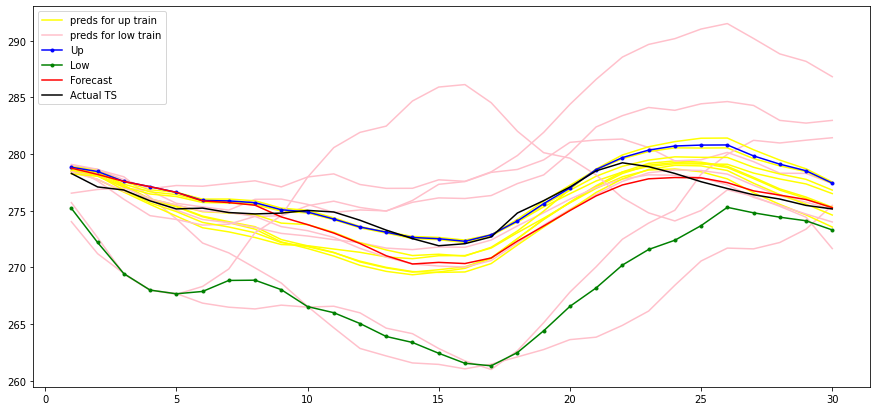

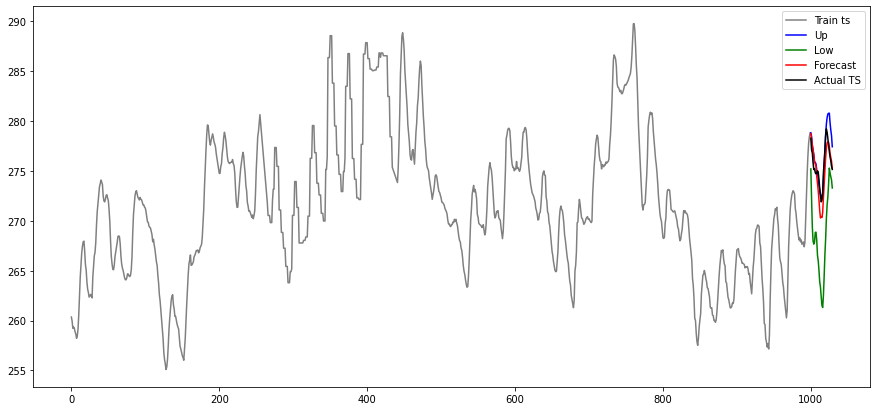

In [58]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = True,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)